<a href="https://colab.research.google.com/github/RadimKozl/Neural-network-research/blob/main/LSTM_development.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **<font style="color:black">Development of new version of LSTM function of PyTorch</font>**

#### **<font style="color:purple">Import libraries</font>**

In [ ]:
import random

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import numpy as np

seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## **<font style="color:blue">Introduction and theory</font>**

<p>
Long Short-Term Memory (LSTM) networks are a type of recurrent neural network (RNN) designed to address the vanishing gradient problem, which can make it difficult for standard RNNs to learn long-term dependencies. LSTMs have a more complex architecture than standard RNNs, with additional components that allow them to selectively remember or forget information over time.
<p>

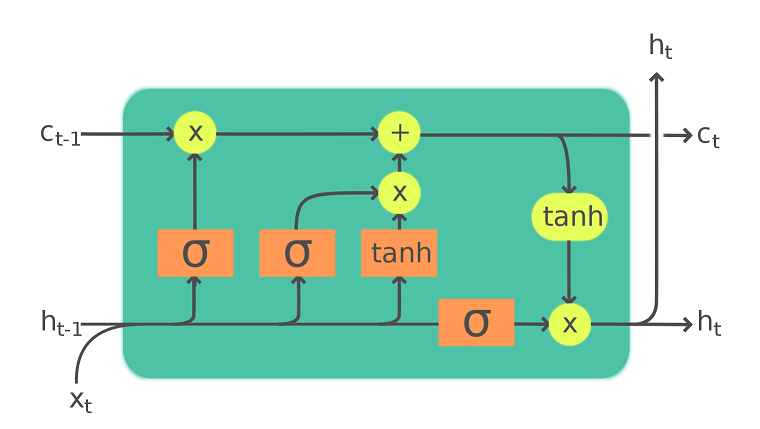

[resource of image](https://www.quantconnect.com/docs/v2/research-environment/applying-research/long-short-term-memory)

### **<font style="color:brown">Key Components of LSTM</font>**

1. ***Cell State (C_t):*** This is the horizontal line that runs straight through the entire chain, carrying information along the sequence.

2. ***Hidden State (h_t):*** This is the output of the LSTM unit, which is also passed to the next LSTM unit in the sequence.

3. ***Gates:*** LSTMs have three types of gates that control the flow of information:

- ***Forget Gate (f_t):*** Decides what information to throw away from the cell state.
- ***Input Gate (i_t):*** Decides what new information to store in the cell state.
- ***Output Gate (o_t):*** Decides what the next hidden state should be.
<br />

### **<font style="color:brown">Mathematical Formulation</font>**

The LSTM updates can be described by the following equations:

1. **Forget Gate:**

$$f_t​=\sigma(Wf​⋅[h_{t−1}​,x_t​]+b_f​)$$

2. **Input Gate:**

$$i_t​=\sigma(W_i​⋅[h_{t−1}​,x_t​]+b_i​)$$

3. **Candidate Cell State:**

$$\widetilde{C}_t​=tanh(W_C​⋅[h_{t−1​},x_t​]+b_C​)$$

4. **Update Cell State:**

$$C_t​=f_t \odot C_{t−1} ​+ i_t \odot \widetilde{C}_t​$$

5. **Output Gate:**

$$o_t​=\sigma(W_o​⋅[h_{t−1}​,x_t​]+b_o​)$$

6. **Hidden State:**

$$h_t​=o_t \odot tanh(C_t​)$$


Here, $\sigma$ is the sigmoid function, $tanh$ is the hyperbolic tangent function, $\odot$ denotes element-wise multiplication, and $W_f,W_i,W_C,W_o$​ are weight matrices.

## **<font style="color:blue">PyTorch Implementation</font>**

In PyTorch, you can use the **nn.LSTM** module to create an *LSTM* layer. Here's a simple example of how to use it:

In [ ]:
# Define an LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        # Initialize cell state
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Example usage
input_size = 10
hidden_size = 20
num_layers = 2
output_size = 1

model = LSTMModel(input_size, hidden_size, num_layers, output_size)

# Dummy input: (batch_size, seq_length, input_size)
dummy_input = torch.randn(5, 3, input_size)
output = model(dummy_input)
print(output)


tensor([[ 0.0228],
        [ 0.0086],
        [ 0.0073],
        [ 0.0038],
        [-0.0164]], grad_fn=<AddmmBackward0>)


## **<font style="color:blue">Implementing an LSTM from scratch in *PyTorch*</font>**

In [ ]:
class LSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMCell, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size

        # Weights for input, forget, cell, and output gates
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))

        self.W_f = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))

        self.W_c = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))

        self.W_o = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        self.init_weights()

    def init_weights(self):
        # Initialize weights and biases
        for weight in [self.W_i, self.W_f, self.W_c, self.W_o]:
            nn.init.xavier_uniform_(weight)
        for bias in [self.b_i, self.b_f, self.b_c, self.b_o]:
            nn.init.zeros_(bias)

    def forward(self, x, h_prev, c_prev):
        # Concatenate input and previous hidden state
        combined = torch.cat((x, h_prev), dim=1)

        # Compute gates
        i_t = torch.sigmoid(torch.mm(combined, self.W_i.t()) + self.b_i)
        f_t = torch.sigmoid(torch.mm(combined, self.W_f.t()) + self.b_f)
        c_tilde = torch.tanh(torch.mm(combined, self.W_c.t()) + self.b_c)
        o_t = torch.sigmoid(torch.mm(combined, self.W_o.t()) + self.b_o)

        # Update cell state
        c_t = f_t * c_prev + i_t * c_tilde

        # Compute new hidden state
        h_t = o_t * torch.tanh(c_t)

        return h_t, c_t

# Example usage
input_size = 10
hidden_size = 20

lstm_cell = LSTMCell(input_size, hidden_size)

# Dummy input: (batch_size, input_size)
dummy_input = torch.randn(5, input_size)
h_prev = torch.zeros(5, hidden_size)
c_prev = torch.zeros(5, hidden_size)

h_t, c_t = lstm_cell(dummy_input, h_prev, c_prev)
print("Hidden State:", h_t)
print("Cell State:", c_t)

Hidden State: tensor([[-0.0973,  0.0518,  0.1359,  0.1605, -0.0162, -0.2975,  0.1552,  0.0109,
         -0.0031, -0.0307,  0.0769, -0.0477,  0.0121,  0.0961,  0.0746, -0.0845,
          0.0091,  0.1223, -0.1350, -0.1493],
        [-0.0231, -0.0657,  0.1393, -0.0051, -0.0636, -0.0885, -0.0025,  0.0142,
         -0.0646,  0.0610,  0.1431, -0.2141,  0.0104,  0.1467, -0.1439,  0.0110,
          0.1121, -0.0518, -0.0680, -0.1550],
        [-0.1543,  0.1479, -0.0275,  0.0965,  0.1511, -0.0451,  0.1045, -0.2488,
         -0.1114, -0.1376, -0.0292,  0.0849,  0.0206, -0.2270,  0.0945, -0.1194,
         -0.1333,  0.0739, -0.0785,  0.1529],
        [-0.0280,  0.1888,  0.1223,  0.2798,  0.0995,  0.0252, -0.1003,  0.0172,
         -0.0353, -0.0634,  0.2490,  0.0250,  0.0518, -0.0346,  0.1327, -0.0633,
          0.0481, -0.0264, -0.1125, -0.1477],
        [ 0.0444,  0.0109,  0.1226,  0.2370,  0.0926, -0.1626, -0.1390,  0.2239,
          0.1013, -0.1249,  0.2534,  0.0486,  0.1009,  0.0440,  0.2289,  

## **<font style="color:blue">Implementing an LSTM as function from scratch in *PyTorch*</font>**

## **<font style="color:green">Definition LSTM as function</font>**

In [ ]:
def lstm_cell(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh):
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])
    cell_state = forget_gate * cell_state + input_gate * cell_gate
    hidden_state = output_gate * torch.tanh(cell_state)
    return hidden_state, cell_state

### **<font style="color:green">Application lstm_cell function</font>**

In [ ]:
class LSTMModelFunctional(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModelFunctional, self).__init__()
        self.hidden_size = hidden_size
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell(x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh, self.bias_ih, self.bias_hh)
            hidden_seq.append(h_t)

        # Use the hidden state of the last time step for the output
        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20

lstm_cell = LSTMCell(input_size, hidden_size)

# Dummy input: (batch_size, input_size)
dummy_input = torch.randn(5, input_size)
h_prev = torch.zeros(5, hidden_size)
c_prev = torch.zeros(5, hidden_size)

h_t, c_t = lstm_cell(dummy_input, h_prev, c_prev)
print("Hidden State:", h_t)
print("Cell State:", c_t)

Hidden State: tensor([[ 0.0858,  0.1628,  0.1159, -0.1233,  0.0329,  0.1039, -0.0645,  0.1323,
          0.0777, -0.0246, -0.0279, -0.0986, -0.0848,  0.0360, -0.2882,  0.1021,
          0.0916, -0.0509,  0.1745, -0.1289],
        [ 0.2685, -0.0119, -0.1421, -0.0694,  0.0433,  0.1370,  0.0033, -0.3760,
         -0.0515,  0.1041, -0.1045,  0.0100,  0.1204, -0.0468,  0.1778, -0.0225,
         -0.2219, -0.1710,  0.0006, -0.0446],
        [ 0.0522, -0.0498, -0.0652, -0.0503, -0.0022,  0.0910, -0.1353, -0.0701,
          0.0654, -0.0510,  0.0517, -0.0802, -0.0332,  0.0346, -0.1258,  0.0390,
         -0.0013,  0.0678, -0.0687, -0.1361],
        [ 0.1389, -0.2207, -0.0078, -0.1218,  0.0273,  0.0943,  0.1491,  0.2600,
          0.0694, -0.0435,  0.0701, -0.0528, -0.0307, -0.1070, -0.2187, -0.0548,
          0.0007,  0.1083,  0.1124, -0.2144],
        [-0.0434,  0.0200, -0.0083, -0.0382,  0.0857,  0.0419, -0.1693,  0.1107,
          0.2008,  0.0618,  0.0051, -0.0753, -0.0479,  0.0421, -0.0668,  

## **<font style="color:blue">Entropy theory</font>**

------------------------------------------------

- Entropy is a physical quantity that characterizes the degree of disorder (chaos) of a system at the microscopic level. The more microscopic arrangements (microstates) correspond to a given macroscopic state of the system, the higher its entropy.

- Intuitively, we can think of entropy as a measure of our ignorance about the exact microscopic state of a system. If entropy is high, there are many possible microscopic arrangements that lead to the same observed macroscopic state, and we therefore know little about the internal organization of the system. Conversely, low entropy means that there are few possible microstates, and our description of the system is therefore more precise.

#### ***Entropy appears in many areas of science:***

- ***Thermodynamics***: Entropy is a key concept in the second law of thermodynamics, which states that the total entropy of an isolated system tends to increase with time or remain constant (for reversible processes). Spontaneous processes in isolated systems always lead to an increase in entropy.

- ***Statistical mechanics***: Here, entropy is defined in terms of the number of microstates corresponding to a given macrostate.

- ***Information theory***: Entropy here measures the amount of information contained in a message or data source. It expresses the average number of bits needed to encode a symbol from the source.

#### ***Mathematical expression:***

1. **Thermodynamic entropy (change):**

- For a reversible process, the infinitesimal change in entropy $\mathrm{d}S$ is defined as the ratio of the infinitesimal amount of heat $\mathrm{d}Q$ supplied to the system to the absolute temperature $T$:

$$ \mathrm{d}S = \mathrm{d}Q / T$$

- For a general process between two states, the entropy change $ \bigtriangleup S$ is given by the integral:

$$ \bigtriangleup S = \int\text{(from state 1 to state 2)} \; \mathrm{d}Q / T$$

2. **Statistical entropy (Boltzmann definition):**

- Ludwig Boltzmann defined the entropy $S$ microscopically in terms of the number of possible microstates $\Omega$ corresponding to a given macroscopic state:

$$S = k_B * ln(\Omega)$$

- where:
  - $S$ is entropy
  - $k_B$ is the Boltzmann constant (approximately $1.38 \times 10^⁻²³$ J/K)
  - $ln(\Omega)$ is the natural logarithm of the number of microstates

- This equation shows that entropy is directly proportional to the logarithm of the number of possible arrangements of the particles of a system that lead to the observed macroscopic state. A higher number of microstates means a higher entropy.

3. **Information entropy (Shannon entropy):**

- In information theory, Claude Shannon defines the entropy $H$ of a discrete random variable $X$ with possible values ​$\{ x_1,x_2, \cdots, x_n \}$ and corresponding probabilities ​$\{ p_1,p_2, \cdots, p_n \}$ as:

$$H(X) = - \sum(i=1\, \text{until}\, n) p_i * log_2(p_i)$$

- where:
  - $H(X)$ is the entropy of the random variable $X$ (measured in bits)
  - $p_i$ is the probability of occurrence of value $x_i$
  - $log_2(p_i)$ is the logarithm to base $2$ of the probability $p_i$

- This equation measures the average amount of information (uncertainty) associated with a random variable. Maximum entropy occurs when all possible values ​​are equally likely.

#### ***Summary:***

- Entropy is a fundamental concept that describes the tendency of systems to move towards greater disorder or uncertainty. Its mathematical expression varies depending on the context (thermodynamics, statistical mechanics, information theory), but all definitions share a common basis in the idea of ​​the number of possible states or the probability of their occurrence.

## **<font style="color:blue">Increasing the efficiency of LSTM and implementing the attention mechanism</font>**

<p>The fundamental idea behind implementing attention into an LSTM is to allow the LSTM at each time step to selectively focus on the most relevant parts of the entire input sequence (or the history of its own hidden states) when making a prediction or generating an output.</p>

- **The Limitation of Standard LSTMs:**
  - Standard LSTMs process sequential data step-by-step, maintaining a hidden state that aims to capture the essence of the sequence seen so far.
  - While LSTMs are better at handling long-range dependencies than simple RNNs, they still have a bottleneck: the entire history of the sequence is compressed into a fixed-size hidden state vector at each time step.
  - This fixed-size vector might struggle to retain all the crucial information from a long input sequence, especially when different parts of the sequence are important for different output steps.

- **Solution using the attention mechanism:**
  - Instead of relying solely on the last hidden state, attention mechanisms enable the LSTM to "look back" at the entire sequence of previous hidden states (or even the original input embeddings).
  - It learns to assign a "weight" or "importance score" to each of these past hidden states (or inputs) based on their relevance to the current decoding step or prediction task.
  - These weights determine how much influence each past state has on the current hidden state and the subsequent output.
  - A "context vector" is then created by taking a weighted sum of these past hidden states (or inputs), where the weights are the attention scores. This context vector represents the focused information from the past that is most relevant right now.
  - This context vector is then used in conjunction with the current LSTM hidden state to make a more informed decision.

- **Summary:**
  - Attention enhances LSTM's memory by providing a mechanism to dynamically access and weigh different parts of the input history, rather than relying solely on the compressed information in the last hidden state. This allows the model to handle longer sequences and focus on the most important information for the current task.

### **<font style="color:brown">Mathematical Formulation for LSTM and implementing the attention mechanism</font>**

**1. Inputs at time step $t$:**

- $x_t$​: Input tensor at time step $t$.
- $h_{t−1}$​: Hidden state from the previous time step $t−1$.
- $c_{t−1}$​: The state of the cell from the previous time step $t−1$.
- $W_{ih}​$​: Weight matrix for transforming the input tensor.
- $W_{hh}$​: Weight matrix for the hidden state transformation.
- $b_{ih}$​: Bias vector for transforming the input tensor.
- $W_{attn}​$: Weight matrix for calculating attention scores.
- $H_{\text{prev}}​=[h_1​,h_2​,...,h_{t−1}​]$: Sequence of hidden states from previous time steps.

**2. Calculations at time step $t$:**

- *Fused linear transformation for gates:*

$$
\mathbf{gates} = x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh}
$$
<br /><p>Here <strong>gates</strong> is the concatenation of vectors for the input gate, the forget gate, the output gate, and the candidate state of the cell.</p>

- *Dividing gates and applying activation functions:*
$$
i_t = \sigma(\mathbf{\text{gates}}_{[0:n]})
$$

$$
f_t = \sigma(\mathbf{\text{gates}}_{[n:2n]})
$$

$$
o_t = \sigma(\mathbf{\text{gates}}_{[2n:3n]})
$$

$$
g_t = \tanh(\mathbf{\text{gates}}_{[3n:4n]})
$$

where $n$ is the dimension of the hidden state and $\sigma$ is the sigmoid function.

- *Cell status update:*

$$
c_t = f_t \odot c_{t-1} + i_t \odot g_t
$$

where $\odot$ denotes element by element multiplication.

- *Calculating attention score:*

$$
\mathbf{\text{attention_scores}} = h_{t-1} W_{attn}^T
$$

- *Normalization of attention weights using Softmax:*

$$
\mathbf{\text{attention_weights_normalized}} = \mathbf{\text{softmax}}(\mathbf{\text{attention_scores}})
$$

The softmax function is applied over the dimension of the sequence of previous hidden states.

- *Calculating the context vector:*

$$
\mathbf{\text{context_vector}} = \mathbf{\text{attention_weights_normalized}} \, H_{prev}
$$

This is a weighted sum of the previous hidden states, where the weights are the normalized attention scores.

- *Updating the hidden state with the context vector:*

$$
h_t = o_t \odot \tanh(c_t) + \mathbf{\text{context_vector}}
$$

**3. Outputs at time step $t$:**

- $h_t$​: New hidden state.
- $c_t$​: New cell state.

## **<font style="color:blue">Implementing an LSTM with attention as function from scratch in *PyTorch*</font>**

## **<font style="color:green">Definition LSTM with attention as function</font>**

In [ ]:
def lstm_cell_with_attention(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh, attention_weights, previous_hidden_states, timestep):
    """
    Calculation of a single step of an LSTM cell with an attention mechanism.

    Args:
        input_tensor: Input tensor (x_t)
        hidden_state: Hidden state from the previous step (h_{t-1})
        cell_state: Cell state from the previous step (c_{t-1})
        weights_ih: Weights for the input tensor
        weights_hh: Weights for the hidden state
        bias_ih: Biases for the input tensor
        bias_hh: Biases for the hidden state
        attention_weights: Attention weights
        previous_hidden_states: Hidden states from previous steps
        timestep: Current timestep in the sequence

    Returns:
        New hidden state (h_t) and new cell state (c_t)
    """

    # Linear transformation (fused)
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh

    # Splitting into individual gates
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])

    # Updating the cell state
    cell_state = forget_gate * cell_state + input_gate * cell_gate

    # Attention mechanism
    # Use previous hidden states up to the current timestep
    relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]  # Shape: (batch_size, timestep + 1, hidden_size)
    # Compute attention scores: (batch_size, timestep + 1)
    attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)
    attention_weights_normalized = F.softmax(attention_scores, dim=1).unsqueeze(1)  # Shape: (batch_size, 1, timestep + 1)
    context_vector = torch.bmm(attention_weights_normalized, relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)

    # Updating the hidden state with the context vector
    hidden_state = output_gate * torch.tanh(cell_state) + context_vector

    return hidden_state, cell_state

### **<font style="color:green">Application lstm_cell_with_attention function</font>**

In [ ]:
class LSTMModelWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModelWithAttention, self).__init__()
        self.hidden_size = hidden_size
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))  # Not strictly needed now
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell_with_attention(
                x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh,
                self.bias_ih, self.bias_hh, self.attention_weights, previous_hidden_states, t
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t


# Example usage
input_size = 10
hidden_size = 20
output_size = 1

lstm_cell_attention = LSTMModelWithAttention(input_size, hidden_size, output_size)

# Dummy input data: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3

# Create random input data
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_cell_attention(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[ 0.1015],
        [-0.0449],
        [ 0.0010],
        [ 0.0392],
        [ 0.1341]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[ 0.0882, -0.1784,  0.0039,  0.0837, -0.2128,  0.0820, -0.0321, -0.0066,
          0.2133,  0.0309,  0.1246,  0.0259, -0.1533, -0.2955,  0.4019,  0.0460,
          0.1894, -0.0618,  0.0306, -0.1781],
        [ 0.1457, -0.0239,  0.2166, -0.2845, -0.2422, -0.1706,  0.2590,  0.0493,
         -0.1159, -0.2796, -0.1448,  0.1293,  0.2497, -0.3194, -0.2288,  0.2632,
          0.0342, -0.2411, -0.2518, -0.3998],
        [ 0.0378,  0.0127,  0.1102,  0.0433, -0.0446, -0.0339, -0.3328,  0.2969,
         -0.2958,  0.2327, -0.1518,  0.4233,  0.0942,  0.0331, -0.0283, -0.0565,
         -0.1087, -0.0194,  0.1659, -0.0982],
        [ 0.1655,  0.2254, -0.0366,  0.1867, -0.0936, -0.0770, -0.1562, -0.3606,
         -0.1582,  0.0895,  0.0008,  0.0382,  0.0042, -0.0968,  0.1960, -0.2393,
          0.0850, -0.1398, -0.0178,  0.1000],
        [ 0.2024,

## **<font style="color:blue">Implementing an LSTM with attention from scratch in *PyTorch*</font>**

In [ ]:
class LSTMCellWithAttention(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMCellWithAttention, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size

        # Weights for input-to-hidden transformations (gates)
        self.W_i = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))  # Input gate
        self.W_f = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))  # Forget gate
        self.W_c = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))  # Cell gate
        self.W_o = nn.Parameter(torch.Tensor(hidden_size, input_size + hidden_size))  # Output gate

        # Biases for gates
        self.b_i = nn.Parameter(torch.Tensor(hidden_size))
        self.b_f = nn.Parameter(torch.Tensor(hidden_size))
        self.b_c = nn.Parameter(torch.Tensor(hidden_size))
        self.b_o = nn.Parameter(torch.Tensor(hidden_size))

        # Attention layer (optional: could use a simpler dot-product attention if preferred)
        self.attention = nn.Linear(hidden_size, hidden_size, bias=False)

        # Final fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        self.init_weights()

    def init_weights(self):
        # Initialize weights and biases using Xavier for weights and zeros for biases
        for weight in [self.W_i, self.W_f, self.W_c, self.W_o]:
            nn.init.xavier_uniform_(weight)
        for bias in [self.b_i, self.b_f, self.b_c, self.b_o]:
            nn.init.zeros_(bias)
        nn.init.xavier_uniform_(self.attention.weight)

    def forward(self, x, h_prev=None, c_prev=None):
        """
        Forward pass for the LSTM cell with attention over the sequence.

        Args:
            x: Input tensor of shape (batch_size, seq_length, input_size)
            h_prev: Previous hidden state (batch_size, hidden_size), optional
            c_prev: Previous cell state (batch_size, hidden_size), optional

        Returns:
            output: Final output after fully connected layer (batch_size, output_size)
            h_t: Final hidden state (batch_size, hidden_size)
            c_t: Final cell state (batch_size, hidden_size)
        """
        batch_size, seq_length, _ = x.size()

        # Initialize hidden and cell states if not provided
        if h_prev is None:
            h_prev = torch.zeros(batch_size, self.hidden_size, device=x.device)
        if c_prev is None:
            c_prev = torch.zeros(batch_size, self.hidden_size, device=x.device)

        # Store hidden states for attention
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            # Concatenate current input and previous hidden state
            combined = torch.cat((x[:, t, :], h_t), dim=1)

            # Compute gates
            i_t = torch.sigmoid(torch.mm(combined, self.W_i.t()) + self.b_i)
            f_t = torch.sigmoid(torch.mm(combined, self.W_f.t()) + self.b_f)
            c_tilde = torch.tanh(torch.mm(combined, self.W_c.t()) + self.b_c)
            o_t = torch.sigmoid(torch.mm(combined, self.W_o.t()) + self.b_o)

            # Update cell state
            c_t = f_t * c_t + i_t * c_tilde

            # Compute attention over previous hidden states up to this timestep
            relevant_hidden_states = previous_hidden_states[:, :t + 1, :]  # Shape: (batch_size, t + 1, hidden_size)
            if t > 0:  # Apply attention only if there are previous states
                # Compute attention scores
                attention_scores = torch.bmm(relevant_hidden_states, h_t.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, t + 1)
                attention_weights = F.softmax(attention_scores, dim=1).unsqueeze(1)  # Shape: (batch_size, 1, t + 1)
                context_vector = torch.bmm(attention_weights, relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)
            else:
                context_vector = torch.zeros(batch_size, self.hidden_size, device=x.device)  # No context at t=0

            # Update hidden state with attention
            h_t = o_t * torch.tanh(c_t) + context_vector

            # Store the hidden state
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        # Final output through fully connected layer
        output = self.fc(h_t)

        return output, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1

# Initialize the model
lstm_cell_attention = LSTMCellWithAttention(input_size, hidden_size, output_size)

# Dummy input: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Optional: Initialize hidden and cell states (if not provided, they'll be zero-initialized)
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
output, h_t, c_t = lstm_cell_attention(dummy_input, h_prev, c_prev)

# Print the outputs
print("Output:", output)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Output: tensor([[-0.0171],
        [ 0.0226],
        [-0.0569],
        [ 0.0600],
        [-0.1260]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-5.0803e-02,  1.1980e-01,  8.7436e-02, -3.3476e-01,  3.9581e-01,
          1.7821e-02,  2.9325e-01, -2.4422e-01,  2.0424e-01, -9.5694e-02,
         -1.7557e-01,  9.6278e-02,  1.1567e-02, -2.7676e-02,  9.1627e-02,
         -6.6106e-01,  3.7325e-02,  3.6945e-02,  4.7969e-02,  2.7416e-01],
        [-1.2381e-01, -1.7818e-01,  1.8445e-01, -1.8795e-01,  1.8647e-01,
          8.4210e-02,  2.1043e-01,  1.1031e-01, -2.8562e-02,  2.0418e-01,
          2.8955e-01,  3.5968e-01,  2.4528e-02, -2.6598e-01, -3.2298e-01,
         -1.2211e-01, -1.8676e-01,  6.5903e-02, -1.2091e-01, -8.8776e-02],
        [-9.0912e-02, -1.3150e-01,  4.1204e-01, -2.2673e-01,  1.2524e-01,
          8.1597e-02,  2.7153e-01,  9.1321e-02,  3.7137e-01, -1.0550e-01,
          5.0954e-02, -1.3432e-01, -2.6648e-01,  7.4932e-02,  2.0463e-01,
         -9.9504e-02,  1.9934e-01,

## **<font style="color:blue">Implementation of entropy into the attention mechanism in LSTM networks</font>**

#### ***Overview of methods:***

**1. Entropic regularization:**

- **Basic idea:** This variant tries to influence the distribution of attention weights so that it is not too "sharp" or focused on only a few elements from the past. It is inspired by the principle of entropy, which prefers a more even distribution of probabilities (in this case, weights).

- **How it works:** During training, the entropy of the normalized attention weights is calculated. If the weights are too concentrated (low entropy), a penalty is added to the model's loss function. This forces the model to assign attention to a wider range of past states, potentially preventing over-reliance on a few "most important" points and improving generalization.

- **Physical analogy:** Imagine a system of particles that can move in space. Low entropy would correspond to a state where all the particles are clustered in a small area. High entropy would correspond to a uniform distribution of particles throughout the space. Low entropy regularization penalizes attention clustering.

**2. Time factor (time decay):**

- **Basic idea:** This variant introduces a mechanism that reduces the importance (weight) of older information from the past when calculating the context vector. This simulates the effect of entropy, where information becomes less relevant or "degrades" over time.

- **How it works:** A time-dependent function (such as exponential decay) is applied to the attention weights. The further back in time a hidden state is, the less weight it has in computing the context vector. This forces the model to focus more on recent history, which can be useful in tasks where recent events are more relevant for prediction.

- **Physical analogy:** Think of memories. The older a memory is, the less detailed and less reliable it becomes (unless it is actively retrieved). The time factor in attention simulates this "forgetting" of older information.

**3. Entropic regularization + Time factor + randomness:**

- **Basic idea:** This variant combines the advantages of entropic regularization and the time factor, and additionally introduces an element of randomness into the process of choosing what the model will focus on. It is intended to simulate the chaotic movement of particles and the exploration of the space of possible solutions.

- **How it works:** At each step, there is a certain probability that either entropic regularization, a time factor, or some attention weights are randomly reset (simulating the "heat flow" of attention). This should help the model escape local minima during training and explore a wider space of possible attention distributions.

- **Physical analogy:** Imagine a system with many interacting particles at a certain temperature. The particles are constantly randomly oscillating and interacting. This variant tries to simulate this dynamics in the attention mechanism to avoid getting stuck in suboptimal states.

#### ***Summary:***

Overall, these variants explore different ways in which the principles of entropy and its associated phenomena (tendency to disorder, information degradation over time, random fluctuations) can influence the attention mechanism in LSTM networks and potentially improve their ability to process long sequences and generalize.

## **<font style="color:aqua">Entropic regularization</font>**

### **<font style="color:brown">Mathematical expression with entropic regularization:</font>**

1. **Equations:**

- *Fused linear transformation for gates: (Same as before)*

$$\text{gates} = x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh}$$

- *Dividing the gates and applying activation functions: (Same as before)*

$$i_t = \sigma(\text{gates}_{[0:n]})$$
$$f_t = \sigma(\text{gates}_{[n:2n]})$$
$$o_t = \sigma(\text{gates}_{[2n:3n]})$$
$$g_t = \tanh(\text{gates}_{[3n:4n]})$$

- *Cell status update: (Same as before)*

$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$

- *Attention score calculation: (Same as before)*

$$\text{attention_scores} = h_{t-1} W_{attn}^T$$

- *Normalizing attention weights using Softmax: (Same as before)*

$$\text{attention_weights_normalized} = \text{softmax}(\text{attention_scores})$$

- *Context vector calculation: (Same as before)*

$$\text{context_vector} = \text{attention_weights_normalized} \, H_{prev}$$

- *Calculating the entropy of attention weights:*

$$
H(\mathbf{a}) = - \frac{1}{B} \sum_{b=1}^{B} \sum_{i=1}^{T-1} a_{b,i} \log(a_{b,i} + \epsilon)
$$

where:

  1. $a=\text{attention_weights_normalized}$ is a matrix of normalized attention weights ($\text{dimension Batch Size B} \times {Length}$ of previous sequence $T−1$).

  2. $a_{b,i}$​ is the `i-th` attention weight for the `b-th` element in the batch.
  3. $\epsilon$ is a small positive number (e.g. 1e−8) for the numerical stability of the logarithm.
  4. The result is the average entropy over all elements in the batch.
  <br />

- *Updating the hidden state with context vector and entropic regularization:*

$$
h_t = o_t \odot \tanh(c_t) + \text{context_vector} - \lambda_{entropy} \cdot H(\mathbf{a}) \cdot \mathbf{1}
$$

where:

  1. $\lambda_{entropy}$​ is the entropic regularization coefficient (hyperparameter). Determines how strongly the penalty will be for models that produce too "spiky" attention distributions (low entropy).
  2. $H(\mathbf{a})$ is the calculated entropy.
  3. $\mathbf{1}$ is a vector of ones of the same dimension as the hidden state ht​. In this way, the entropy penalty is applied to all dimensions of the hidden state.

### **<font style="color:darkgreen">Implementing an LSTM with Entropic regularization as function from scratch in *PyTorch*</font>**

#### **<font style="color:green">Definition LSTM with Entropic regularization as function</font>**

In [ ]:
def lstm_cell_attention_entropy_reg(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh, attention_weights, previous_hidden_states, lambda_entropy, timestep):
    """
    Calculation of a single step of an LSTM cell with an attention mechanism and entropic regularization.

    Args:
        input_tensor: Input tensor (x_t)
        hidden_state: Hidden state from the previous step (h_{t-1})
        cell_state: Cell state from the previous step (c_{t-1})
        weights_ih: Weights for the input tensor
        weights_hh: Weights for the hidden state
        bias_ih: Biases for the input tensor
        bias_hh: Biases for the hidden state
        attention_weights: Attention weights (not used directly here, kept for compatibility)
        previous_hidden_states: Hidden states from previous steps
        lambda_entropy: Coefficient of entropic regularization
        timestep: Current timestep in the sequence

    Returns:
        New hidden state (h_t) and new cell state (c_t)
    """
    # Linear transformation (fused)
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh

    # Splitting into individual gates
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])

    # Updating the cell state
    cell_state = forget_gate * cell_state + input_gate * cell_gate

    # Attention mechanism
    relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]  # Shape: (batch_size, timestep + 1, hidden_size)
    if timestep > 0:  # Only apply attention if there are previous states
        # Compute attention scores over the sequence
        attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, timestep + 1)
        attention_weights_normalized = F.softmax(attention_scores, dim=1)  # Shape: (batch_size, timestep + 1)
        context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)

        # Calculate entropy of attention weights
        entropy = -torch.sum(attention_weights_normalized * torch.log(attention_weights_normalized + 1e-8), dim=1).mean()
    else:
        context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)  # No attention at t=0
        entropy = torch.tensor(0.0, device=hidden_state.device)

    # Update hidden state with context vector and entropy regularization
    hidden_state = output_gate * torch.tanh(cell_state) + context_vector - lambda_entropy * entropy

    return hidden_state, cell_state

#### **<font style="color:green">Application lstm_cell_attention_entropy_reg function</font>**

In [ ]:
class LSTMModelWithAttentionEntropyReg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lambda_entropy):
        super(LSTMModelWithAttentionEntropyReg, self).__init__()
        self.hidden_size = hidden_size
        self.lambda_entropy = lambda_entropy
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))  # Kept for compatibility, not used directly
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell_attention_entropy_reg(
                x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh,
                self.bias_ih, self.bias_hh, self.attention_weights, previous_hidden_states, self.lambda_entropy, t
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
lambda_entropy = 0.1  # Example value for entropic regularization coefficient

lstm_cell_attention_entropy = LSTMModelWithAttentionEntropyReg(input_size, hidden_size, output_size, lambda_entropy)

# Dummy input data: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3

# Create random input data
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_cell_attention_entropy(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[-0.2039],
        [-0.1822],
        [-0.1833],
        [-0.2257],
        [-0.2803]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-0.1896, -0.1644, -0.0325, -0.0789, -0.0756,  0.0474, -0.0922,  0.0016,
         -0.2455, -0.0911, -0.2400,  0.0412, -0.2640,  0.0282, -0.1880, -0.0941,
         -0.2342, -0.1917, -0.2191, -0.0964],
        [-0.2550,  0.1991, -0.2754, -0.0173,  0.0715, -0.4109, -0.1724, -0.4193,
         -0.2217, -0.2233,  0.0362, -0.1654, -0.1825, -0.3053, -0.0974, -0.3747,
         -0.0735,  0.0789, -0.3060,  0.1721],
        [-0.2237, -0.2980, -0.1827, -0.1323, -0.0474, -0.0176, -0.0117, -0.2980,
         -0.2792, -0.6225, -0.1663,  0.2069,  0.0129, -0.0955, -0.2543, -0.5427,
         -0.2583,  0.0565, -0.4102, -0.0188],
        [-0.3586, -0.0448, -0.2611,  0.0575,  0.1943, -0.1495, -0.1387, -0.2904,
         -0.3516,  0.0155,  0.1046,  0.0401, -0.2491, -0.2471,  0.0311, -0.1972,
         -0.1641, -0.0288,  0.0086, -0.0520],
        [-0.0359,

### **<font style="color:darkgreen">Implementing an LSTM with Attention and Entropic regularization from scratch in *PyTorch*</font>**

In [ ]:
class LSTMWithAttentionEntropyReg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lambda_entropy):
        super(LSTMWithAttentionEntropyReg, self).__init__()
        self.hidden_size = hidden_size
        self.lambda_entropy = lambda_entropy

        # LSTM weights and biases
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))

        # Attention weights (kept for compatibility, not used directly)
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def lstm_cell_attention_entropy_reg(self, input_tensor, hidden_state, cell_state, previous_hidden_states, timestep):
        # Linear transformation (fused)
        gates = torch.matmul(input_tensor, self.weights_ih.t()) + self.bias_ih + torch.matmul(hidden_state, self.weights_hh.t()) + self.bias_hh

        # Splitting into individual gates
        input_gate = torch.sigmoid(gates[:, 0:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:, self.hidden_size:2 * self.hidden_size])
        output_gate = torch.sigmoid(gates[:, 2 * self.hidden_size:3 * self.hidden_size])
        cell_gate = torch.tanh(gates[:, 3 * self.hidden_size:4 * self.hidden_size])

        # Updating the cell state
        cell_state = forget_gate * cell_state + input_gate * cell_gate

        # Attention mechanism
        relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]  # Shape: (batch_size, timestep + 1, hidden_size)
        if timestep > 0:  # Only apply attention if there are previous states
            # Compute attention scores over the sequence
            attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, timestep + 1)
            attention_weights_normalized = F.softmax(attention_scores, dim=1)  # Shape: (batch_size, timestep + 1)
            context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)

            # Calculate entropy of attention weights
            entropy = -torch.sum(attention_weights_normalized * torch.log(attention_weights_normalized + 1e-8), dim=1).mean()
        else:
            context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)  # No attention at t=0
            entropy = torch.tensor(0.0, device=hidden_state.device)

        # Update hidden state with context vector and entropy regularization
        hidden_state = output_gate * torch.tanh(cell_state) + context_vector - self.lambda_entropy * entropy

        return hidden_state, cell_state

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = self.lstm_cell_attention_entropy_reg(
                x[:, t, :], h_t, c_t, previous_hidden_states, t
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
lambda_entropy = 0.1  # Example value for entropic regularization coefficient

lstm_attention_entropy = LSTMWithAttentionEntropyReg(input_size, hidden_size, output_size, lambda_entropy)

# Dummy input data: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3

# Create random input data
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_attention_entropy(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[ 0.2114],
        [ 0.0290],
        [-0.0084],
        [-0.0736],
        [ 0.0737]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-0.0070, -0.0495, -0.2752,  0.0615, -0.5194, -0.2094, -0.1195,  0.2727,
          0.0814,  0.0543, -0.4781, -0.1982, -0.1221, -0.3339, -0.0385, -0.0234,
         -0.1176, -0.0592, -0.3543, -0.2200],
        [ 0.0406, -0.2710, -0.2743, -0.2181, -0.0642, -0.1334, -0.0652, -0.3198,
         -0.1654, -0.1630, -0.0755,  0.0832, -0.0079, -0.1591, -0.2275, -0.3423,
          0.0059, -0.1045, -0.0116, -0.0641],
        [ 0.0285, -0.2609, -0.2609, -0.0312, -0.2454, -0.1235, -0.3099, -0.1987,
         -0.1123, -0.4523,  0.1828, -0.2153, -0.2300,  0.0601, -0.2447, -0.4044,
         -0.0421, -0.3750, -0.2686, -0.4113],
        [-0.0636, -0.3021,  0.0596, -0.1750, -0.1481, -0.1398, -0.0971, -0.1303,
         -0.1330, -0.2915, -0.2627,  0.0214,  0.0948, -0.1947, -0.0324, -0.4557,
         -0.3211, -0.2672, -0.1322, -0.3268],
        [-0.1269,

## **<font style="color:aqua">Time factor (time decay)</font>**

### **<font style="color:brown">Mathematical expression with time factor:</font>**

1. **Equations:**

- *Fused linear transformation for gates: (Same as before)*

$$\mathbf{\text{gates}} = x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh}$$

- *Dividing the gates and applying activation functions: (Same as before)*

$$i_t = \sigma(\mathbf{gates}_{[0:n]})$$
$$f_t = \sigma(\mathbf{gates}_{[n:2n]})$$
$$o_t = \sigma(\mathbf{gates}_{[2n:3n]})$$
$$g_t = \tanh(\mathbf{gates}_{[3n:4n]})$$

- *Cell status update: (Same as before)*

$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$

- *Attention Score Calculation: (Same as before)*

$$\mathbf{\text{attention_scores}} = h_{t-1} W_{attn}^T$$

- *Applying temporal decay to attention weights:*
  - *First, the nonlinear attention weights are calculated:*

  $$
  \mathbf{\text{attention_weights_unnormalized}} = \exp(\mathbf{\text{attention_scores}})
  $$

  - *Then, time decay is applied:*

  $$
  \mathbf{\text{time_weights}} = \exp(-\delta \cdot [0, 1, \dots, t])
  $$

  >where $\delta$ is the time decay coefficient (time_decay) and $[0,1,\dots,t]$ is the vector of time indices of previous hidden states (relative to the current step).

  - *Combined scales:*

$$
\mathbf{\text{attention_weights_with_decay}} = \mathbf{\text{attention_weights_unnormalized}} \odot \mathbf{\text{time_weights}}
$$

- *Normalization of attention weights with temporal decay:*

$$
\mathbf{\text{attention_weights_normalized}} = \frac{\mathbf{\text{attention_weights_with_decay}}}{\sum_{i=0}^{t} \mathbf{\text{attention_weights_with_decay}}_i}
$$

>Normalization is performed over the dimension of the sequence of previous hidden states.

- *Context vector calculation: (Same as before, but with time-dampened weights)*

$$
\mathbf{\text{context_vector}} = \mathbf{\text{attention_weights_normalized}} \, H_{prev}^{(0:t+1)}
$$

>where $H_{prev}^{(0:t+1)}$ denotes the sequence of previous hidden states up to the current time step

- *Updating the hidden state with the context vector: (Same as before)*

$$
h_t = o_t \odot \tanh(c_t) + \mathbf{\text{context_vector}}
$$

2. **Dependencies:**

  In addition to the dependencies from the clean version with attention, the updated hidden state ht​ now also depends on:

  - Time decay coefficient $\delta$ (`time_decay`).
  - The current time step $t$ for calculating time weights.


### **<font style="color:darkgreen">Implementing an LSTM with Time factor as function from scratch in *PyTorch*</font>**

#### **<font style="color:green">Definition LSTM with Time factor as function</font>**

In [ ]:
def lstm_cell_attention_time_decay(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh, attention_weights, previous_hidden_states, timestep, time_decay):
    """
    Calculation of a single step of an LSTM cell with an attention mechanism and time decay.

    Args:
        input_tensor: Input tensor (x_t)
        hidden_state: Hidden state from the previous step (h_{t-1})
        cell_state: Cell state from the previous step (c_{t-1})
        weights_ih: Weights for the input tensor
        weights_hh: Weights for the hidden state
        bias_ih: Biases for the input tensor
        bias_hh: Biases for the hidden state
        attention_weights: Attention weights (not used directly here, kept for compatibility)
        previous_hidden_states: Hidden states from previous steps
        timestep: Current timestep in the sequence
        time_decay: Coefficient of time decay

    Returns:
        New hidden state (h_t) and new cell state (c_t)
    """

    # Linear transformation (fused)
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh

    # Splitting into individual gates
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])

    # Updating the cell state
    cell_state = forget_gate * cell_state + input_gate * cell_gate

    # Attention
    relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]
    if timestep > 0:
        # Compute attention scores
        attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)
        attention_weights_unnormalized = torch.exp(attention_scores) # Using exponential for non-negative weights

        # Apply time decay to attention weights
        time_weights = torch.exp(-time_decay * torch.arange(timestep + 1).float().to(input_tensor.device))
        time_weights = time_weights.unsqueeze(0) # Add batch dimension
        attention_weights_with_decay = attention_weights_unnormalized * time_weights

        # Normalize attention weights with decay
        attention_weights_normalized = attention_weights_with_decay / torch.sum(attention_weights_with_decay, dim=1, keepdim=True)

        # Compute context vector
        context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)
    else:
        context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)

    # Updating the hidden state with the context vector
    hidden_state = output_gate * torch.tanh(cell_state) + context_vector

    return hidden_state, cell_state

#### **<font style="color:green">Application lstm_cell_attention_time_decay function</font>**

In [ ]:
class LSTMModelWithAttentionTimeDecay(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_decay):
        super(LSTMModelWithAttentionTimeDecay, self).__init__()
        self.hidden_size = hidden_size
        self.time_decay = time_decay
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) # Kept for compatibility
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell_attention_time_decay(
                x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh,
                self.bias_ih, self.bias_hh, self.attention_weights, previous_hidden_states, t, self.time_decay
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
time_decay = 0.1 # Example value for time decay coefficient

lstm_cell_attention_decay = LSTMModelWithAttentionTimeDecay(input_size, hidden_size, output_size, time_decay)

# Dummy input data
batch_size = 5
seq_length = 3
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_cell_attention_decay(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[-0.2462],
        [-0.2267],
        [-0.1978],
        [-0.2007],
        [-0.0557]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-0.2260,  0.0501,  0.1519, -0.1547, -0.1071,  0.0655, -0.0388, -0.1138,
          0.3055, -0.1080,  0.0231, -0.0923,  0.1430,  0.0915,  0.3307, -0.2310,
          0.0665,  0.0929, -0.0202,  0.0228],
        [-0.1716, -0.2355, -0.3021,  0.3116,  0.1555, -0.3448, -0.1408, -0.3954,
         -0.2097,  0.0034,  0.1344, -0.1456, -0.1281,  0.3666, -0.2645,  0.1204,
         -0.1859,  0.1279,  0.0859, -0.2702],
        [-0.0016,  0.4163, -0.0074, -0.0998,  0.0203, -0.0492,  0.0128,  0.0075,
          0.1132, -0.0957,  0.1964,  0.1796,  0.1021, -0.1004,  0.0075,  0.0749,
         -0.0849,  0.0921, -0.0986,  0.2324],
        [ 0.0453, -0.1593,  0.1412,  0.1954,  0.1722,  0.0193,  0.1081, -0.0715,
          0.0897, -0.0848,  0.0417,  0.0289, -0.2367, -0.0887, -0.2077,  0.0742,
          0.1615, -0.0897, -0.2112, -0.2190],
        [-0.2025,

### **<font style="color:darkgreen">Implementing an LSTM with Attention and Time factor from scratch in *PyTorch*</font>**

In [ ]:
class LSTMWithAttentionTimeDecay(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, time_decay):
        super(LSTMWithAttentionTimeDecay, self).__init__()
        self.hidden_size = hidden_size
        self.time_decay = time_decay

        # LSTM weights and biases
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))

        # Attention weights (kept for compatibility, not used directly)
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def lstm_cell_attention_time_decay(self, input_tensor, hidden_state, cell_state, previous_hidden_states, timestep):
        # Linear transformation (fused)
        gates = torch.matmul(input_tensor, self.weights_ih.t()) + self.bias_ih + torch.matmul(hidden_state, self.weights_hh.t()) + self.bias_hh

        # Splitting into individual gates
        input_gate = torch.sigmoid(gates[:, 0:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:, self.hidden_size:2 * self.hidden_size])
        output_gate = torch.sigmoid(gates[:, 2 * self.hidden_size:3 * self.hidden_size])
        cell_gate = torch.tanh(gates[:, 3 * self.hidden_size:4 * self.hidden_size])

        # Updating the cell state
        cell_state = forget_gate * cell_state + input_gate * cell_gate

        # Attention mechanism
        relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]  # Shape: (batch_size, timestep + 1, hidden_size)
        if timestep > 0:  # Only apply attention if there are previous states
            # Compute attention scores
            attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, timestep + 1)
            attention_weights_unnormalized = torch.exp(attention_scores)  # Using exponential for non-negative weights

            # Apply time decay to attention weights
            time_weights = torch.exp(-self.time_decay * torch.arange(timestep + 1).float().to(input_tensor.device))
            time_weights = time_weights.unsqueeze(0)  # Add batch dimension
            attention_weights_with_decay = attention_weights_unnormalized * time_weights

            # Normalize attention weights with decay
            attention_weights_normalized = attention_weights_with_decay / torch.sum(attention_weights_with_decay, dim=1, keepdim=True)

            # Compute context vector
            context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)
        else:
            context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)  # No attention at t=0

        # Update hidden state with context vector
        hidden_state = output_gate * torch.tanh(cell_state) + context_vector

        return hidden_state, cell_state

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = self.lstm_cell_attention_time_decay(
                x[:, t, :], h_t, c_t, previous_hidden_states, t
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
time_decay = 0.1  # Example value for time decay coefficient

lstm_attention_decay = LSTMWithAttentionTimeDecay(input_size, hidden_size, output_size, time_decay)

# Dummy input data: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3

# Create random input data
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_attention_decay(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)


Outputs: tensor([[0.1389],
        [0.0466],
        [0.1392],
        [0.0197],
        [0.0246]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[ 1.4313e-01,  1.6179e-02,  3.0502e-02, -4.5134e-02, -1.3699e-03,
         -2.7853e-03,  6.2097e-03,  7.9815e-02, -7.2384e-02, -1.2825e-01,
          5.3441e-02,  1.0082e-01,  7.0604e-02,  1.5558e-01,  3.2993e-02,
          1.1097e-02,  1.1083e-01,  2.3524e-02,  1.0120e-02, -8.4956e-02],
        [ 7.0549e-02, -1.0550e-01,  6.0895e-02,  4.5357e-02, -1.5814e-01,
         -5.8171e-02,  6.5578e-02, -2.3328e-02,  3.4137e-05,  5.3071e-02,
         -2.9496e-03, -2.3341e-01, -1.5708e-01, -7.1465e-02,  1.2531e-02,
         -5.5645e-02, -8.5341e-02, -1.4951e-01, -2.6062e-02, -6.0741e-02],
        [ 1.5467e-01, -1.3091e-01,  2.9337e-01,  9.1580e-02,  2.8709e-01,
         -7.0603e-02, -1.1427e-02, -1.3236e-01,  4.0336e-02, -8.8092e-03,
         -1.1652e-01,  7.6264e-02,  1.3618e-01, -7.8744e-02, -3.2453e-01,
          2.1617e-01,  2.1717e-01,  2.

## **<font style="color:aqua">Entropic regularization + Time factor + randomness</font>**

### **<font style="color:brown">Mathematical expression with a combination of entropy, time factor and randomness:</font>**


1. **Equations:**

- *Fused linear transformation for gates: (Same as before)*

$$\mathbf{\text{gates}} = x_t W_{ih}^T + b_{ih} + h_{t-1} W_{hh}^T + b_{hh}$$

- *Dividing the gates and applying activation functions: (Same as before)*

$$i_t = \sigma(\mathbf{\text{gates}}_{[0:n]})$$
$$f_t = \sigma(\mathbf{\text{gates}}_{[n:2n]})$$
$$o_t = \sigma(\mathbf{\text{gates}}_{[2n:3n]})$$
$$g_t = \tanh(\mathbf{\text{gates}}_{[3n:4n]})$$

- *Cell status update: (Same as before)*

$$c_t = f_t \odot c_{t-1} + i_t \odot g_t$$

- *Attention Score Calculation: (Same as before)*

$$\mathbf{\text{attention_scores}} = h_{t-1} W_{attn}^T$$

- *Time-delay application: (Same as in the time-delay version)*
<br /><br />
$$
\mathbf{\text{attention_weights_unnormalized}} = \exp(\mathbf{\text{attention_scores}})
$$
<br />
$$
\mathbf{\text{time_weights}} = \exp(-\delta \cdot [0, 1, \dots, t])
$$
<br />
$$
\mathbf{\text{attention_weights_with_decay}} = \mathbf{\text{attention_weights_unnormalized}} \odot \mathbf{\text{time_weights}}
$$
<br />
$$
\mathbf{\text{attention_weights_normalized_base}} = \frac{\mathbf{\text{attention_weights_with_decay}}}{\sum_{i=0}^{t} \mathbf{\text{attention_weights_with_decay}}_i}
$$
<br />
- *Application of randomness:*
  With probability $p$ (`random_prob`):
<br /><br />
$$
\mathbf{\text{random_mask}} \sim \text{Bernoulli}(0.5)
$$
<br />
$$
\mathbf{\text{attention_weights_normalized}} = \mathbf{\text{attention_weights_normalized_base}} \odot (1 - \mathbf{\text{random_mask}})
$$
<br />
$$
\mathbf{\text{attention_weights_normalized}} = \frac{\mathbf{\text{attention_weights_normalized}}}{\sum_{i=0}^{t} \mathbf{\text{attention_weights_normalized}}_i + \epsilon}
$$

Otherwise (with probability $1−p$):

$$
\mathbf{\text{attention_weights_normalized}} = \mathbf{\text{attention_weights_normalized_base}}
$$

where $\epsilon$ is a small number for numerical stability.
<br /><br />
- *Context vector calculation: (Same as before, with potentially randomly adjusted weights)*
<br /><br />
$$\mathbf{\text{context_vector}} = \mathbf{\text{attention_weights_normalized}}  \, H_{prev}^{(0:t+1)}$$
<br />
- *Calculation of the entropy of attention weights: (Same as in the version with entropic regularization, on potentially randomly adjusted weights)*
<br />
$$
H(\mathbf{a}) = - \frac{1}{B} \sum_{b=1}^{B} \sum_{i=0}^{t} a_{b,i} \log(a_{b,i} + \epsilon)
$$

where $\mathbf{\text{a}}=\mathbf{\text{attention_weights_normalized}}$.
<br /><br />
- *Hidden state update with context vector and entropic regularization: (Same as in the version with entropic regularization)*

$$
h_t = o_t \odot \tanh(c_t) + \mathbf{\text{context_vector}} - \lambda_{entropy} \cdot H(\mathbf{a}) \cdot \mathbf{1}
$$
<br />

2. **Dependencies:**

In addition to the dependencies from previous versions, the updated hidden state $h_t$​ now also depends on:

- The probability of random resetting of the attention weights $p$ `(random_prob)`.

### **<font style="color:darkgreen">Implementing an LSTM with Entropic regularization + Time factor + randomness as function from scratch in *PyTorch*</font>**

#### **<font style="color:green">Definition LSTM with Entropic regularization + Time factor + randomness as function</font>**

In [ ]:
def lstm_cell_attention_mixed(input_tensor, hidden_state, cell_state, weights_ih, weights_hh, bias_ih, bias_hh, attention_weights, previous_hidden_states, timestep, lambda_entropy, time_decay, random_prob):
    """
    Calculation of a single step of an LSTM cell with an attention mechanism, entropic regularization,
    time decay, and a random element.

    Args:
        input_tensor: Input tensor (x_t)
        hidden_state: Hidden state from the previous step (h_{t-1})
        cell_state: Cell state from the previous step (c_{t-1})
        weights_ih: Weights for the input tensor
        weights_hh: Weights for the hidden state
        bias_ih: Biases for the input tensor
        bias_hh: Biases for the hidden state
        attention_weights: Attention weights (not used directly here, kept for compatibility)
        previous_hidden_states: Hidden states from previous steps
        timestep: Current timestep in the sequence
        lambda_entropy: Coefficient of entropic regularization
        time_decay: Coefficient of time decay
        random_prob: Probability of applying random zeroing of attention weights

    Returns:
        New hidden state (h_t) and new cell state (c_t)
    """
    # Linear transformation (fused)
    gates = torch.matmul(input_tensor, weights_ih.t()) + bias_ih + torch.matmul(hidden_state, weights_hh.t()) + bias_hh

    # Splitting into individual gates
    input_gate = torch.sigmoid(gates[:, 0:hidden_state.shape[1]])
    forget_gate = torch.sigmoid(gates[:, hidden_state.shape[1]:2 * hidden_state.shape[1]])
    output_gate = torch.sigmoid(gates[:, 2 * hidden_state.shape[1]:3 * hidden_state.shape[1]])
    cell_gate = torch.tanh(gates[:, 3 * hidden_state.shape[1]:4 * hidden_state.shape[1]])

    # Updating the cell state
    cell_state = forget_gate * cell_state + input_gate * cell_gate

    # Attention
    relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]
    if timestep > 0:
        # Compute attention scores
        attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)
        attention_weights_unnormalized = torch.exp(attention_scores)

        # Apply time decay
        time_weights = torch.exp(-time_decay * torch.arange(timestep + 1).float().to(input_tensor.device))
        time_weights = time_weights.unsqueeze(0)
        attention_weights_with_decay = attention_weights_unnormalized * time_weights

        # Normalize attention weights
        attention_weights_normalized_base = attention_weights_with_decay / torch.sum(attention_weights_with_decay, dim=1, keepdim=True)

        # Apply randomness
        if random.random() < random_prob:
            random_mask = torch.rand(attention_weights_normalized_base.shape, device=input_tensor.device) < 0.5
            attention_weights_normalized = attention_weights_normalized_base.masked_fill(random_mask, 0)
            attention_weights_normalized = attention_weights_normalized / (torch.sum(attention_weights_normalized, dim=1, keepdim=True) + 1e-8) # Re-normalize
        else:
            attention_weights_normalized = attention_weights_normalized_base

        # Compute context vector
        context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)

        # Calculate entropy of attention weights
        entropy = -torch.sum(attention_weights_normalized * torch.log(attention_weights_normalized + 1e-8), dim=1).mean()
    else:
        context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)
        entropy = torch.tensor(0.0, device=hidden_state.device)

    # Updating the hidden state with the context vector and entropic regularization
    hidden_state = output_gate * torch.tanh(cell_state) + context_vector - lambda_entropy * entropy

    return hidden_state, cell_state

#### **<font style="color:green">Application lstm_cell_attention_mixed function</font>**

In [ ]:
class LSTMModelWithAttentionMixed(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lambda_entropy, time_decay, random_prob):
        super(LSTMModelWithAttentionMixed, self).__init__()
        self.hidden_size = hidden_size
        self.lambda_entropy = lambda_entropy
        self.time_decay = time_decay
        self.random_prob = random_prob
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size)) # Kept for compatibility
        self.fc = nn.Linear(hidden_size, output_size)
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = lstm_cell_attention_mixed(
                x[:, t, :], h_t, c_t, self.weights_ih, self.weights_hh,
                self.bias_ih, self.bias_hh, self.attention_weights, previous_hidden_states, t,
                self.lambda_entropy, self.time_decay, self.random_prob
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
lambda_entropy = 0.01
time_decay = 0.05
random_prob = 0.1

lstm_cell_attention_mixed_model = LSTMModelWithAttentionMixed(input_size, hidden_size, output_size, lambda_entropy, time_decay, random_prob)

# Dummy input data
batch_size = 5
seq_length = 3
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_cell_attention_mixed_model(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[ 0.0235],
        [-0.2290],
        [-0.1742],
        [-0.1607],
        [-0.1948]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-0.0727,  0.1802, -0.1378, -0.0048,  0.0172, -0.0109, -0.4203, -0.2745,
         -0.0861,  0.0189,  0.1795, -0.2878,  0.0609, -0.0398,  0.1126, -0.0660,
          0.1473,  0.2862, -0.0826,  0.0294],
        [ 0.1567, -0.1339, -0.1536,  0.1871, -0.0574, -0.0453, -0.1006, -0.0891,
         -0.3090, -0.1691,  0.0623,  0.1635,  0.1414, -0.0042,  0.3296,  0.0076,
          0.0908, -0.1985,  0.0058,  0.0533],
        [ 0.0530, -0.2494,  0.2186, -0.0128,  0.2669, -0.0144, -0.0541,  0.1120,
         -0.0577,  0.0529,  0.4838, -0.1322,  0.2231, -0.0758, -0.0278, -0.2860,
         -0.4349,  0.0722,  0.1455,  0.1568],
        [ 0.1200, -0.0583,  0.0665,  0.0193,  0.0690,  0.0589, -0.2641,  0.1823,
         -0.2993, -0.1512, -0.0060,  0.1537, -0.2388,  0.0080,  0.2602,  0.2117,
          0.0804, -0.3525, -0.0172,  0.1692],
        [ 0.1531,

### **<font style="color:darkgreen">Implementing an LSTM with Attention and Entropic regularization + Time factor + randomness from scratch in *PyTorch*</font>**

In [ ]:
class LSTMWithAttentionMixed(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, lambda_entropy, time_decay, random_prob):
        super(LSTMWithAttentionMixed, self).__init__()
        self.hidden_size = hidden_size
        self.lambda_entropy = lambda_entropy
        self.time_decay = time_decay
        self.random_prob = random_prob

        # LSTM weights and biases
        self.weights_ih = nn.Parameter(torch.Tensor(4 * hidden_size, input_size))
        self.weights_hh = nn.Parameter(torch.Tensor(4 * hidden_size, hidden_size))
        self.bias_ih = nn.Parameter(torch.Tensor(4 * hidden_size))
        self.bias_hh = nn.Parameter(torch.Tensor(4 * hidden_size))

        # Attention weights (kept for compatibility, not used directly)
        self.attention_weights = nn.Parameter(torch.Tensor(hidden_size, hidden_size))

        # Fully connected layer for output
        self.fc = nn.Linear(hidden_size, output_size)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        nn.init.xavier_uniform_(self.weights_ih)
        nn.init.xavier_uniform_(self.weights_hh)
        nn.init.zeros_(self.bias_ih)
        nn.init.zeros_(self.bias_hh)
        nn.init.xavier_uniform_(self.attention_weights)

    def lstm_cell_attention_mixed(self, input_tensor, hidden_state, cell_state, previous_hidden_states, timestep):
        # Linear transformation (fused)
        gates = torch.matmul(input_tensor, self.weights_ih.t()) + self.bias_ih + torch.matmul(hidden_state, self.weights_hh.t()) + self.bias_hh

        # Splitting into individual gates
        input_gate = torch.sigmoid(gates[:, 0:self.hidden_size])
        forget_gate = torch.sigmoid(gates[:, self.hidden_size:2 * self.hidden_size])
        output_gate = torch.sigmoid(gates[:, 2 * self.hidden_size:3 * self.hidden_size])
        cell_gate = torch.tanh(gates[:, 3 * self.hidden_size:4 * self.hidden_size])

        # Updating the cell state
        cell_state = forget_gate * cell_state + input_gate * cell_gate

        # Attention mechanism
        relevant_hidden_states = previous_hidden_states[:, :timestep + 1, :]  # Shape: (batch_size, timestep + 1, hidden_size)
        if timestep > 0:  # Only apply attention if there are previous states
            # Compute attention scores
            attention_scores = torch.bmm(relevant_hidden_states, hidden_state.unsqueeze(2)).squeeze(2)  # Shape: (batch_size, timestep + 1)
            attention_weights_unnormalized = torch.exp(attention_scores)  # Using exponential for non-negative weights

            # Apply time decay to attention weights
            time_weights = torch.exp(-self.time_decay * torch.arange(timestep + 1).float().to(input_tensor.device))
            time_weights = time_weights.unsqueeze(0)  # Add batch dimension
            attention_weights_with_decay = attention_weights_unnormalized * time_weights

            # Normalize attention weights with decay
            attention_weights_normalized_base = attention_weights_with_decay / torch.sum(attention_weights_with_decay, dim=1, keepdim=True)

            # Apply randomness
            if random.random() < self.random_prob:
                random_mask = torch.rand(attention_weights_normalized_base.shape, device=input_tensor.device) < 0.5
                attention_weights_normalized = attention_weights_normalized_base.masked_fill(random_mask, 0)
                attention_weights_normalized = attention_weights_normalized / (torch.sum(attention_weights_normalized, dim=1, keepdim=True) + 1e-8)  # Re-normalize
            else:
                attention_weights_normalized = attention_weights_normalized_base

            # Compute context vector
            context_vector = torch.bmm(attention_weights_normalized.unsqueeze(1), relevant_hidden_states).squeeze(1)  # Shape: (batch_size, hidden_size)

            # Calculate entropy of attention weights
            entropy = -torch.sum(attention_weights_normalized * torch.log(attention_weights_normalized + 1e-8), dim=1).mean()
        else:
            context_vector = torch.zeros_like(hidden_state, device=hidden_state.device)  # No attention at t=0
            entropy = torch.tensor(0.0, device=hidden_state.device)

        # Update hidden state with context vector and entropy regularization
        hidden_state = output_gate * torch.tanh(cell_state) + context_vector - self.lambda_entropy * entropy

        return hidden_state, cell_state

    def forward(self, x, h_prev, c_prev):
        batch_size, seq_length, _ = x.size()
        hidden_seq = []
        previous_hidden_states = torch.zeros(batch_size, seq_length, self.hidden_size, device=x.device)

        h_t, c_t = h_prev, c_prev
        for t in range(seq_length):
            h_t, c_t = self.lstm_cell_attention_mixed(
                x[:, t, :], h_t, c_t, previous_hidden_states, t
            )
            hidden_seq.append(h_t)
            previous_hidden_states[:, t, :] = h_t

        out = self.fc(hidden_seq[-1])
        return out, h_t, c_t

# Example usage
input_size = 10
hidden_size = 20
output_size = 1
lambda_entropy = 0.01
time_decay = 0.05
random_prob = 0.1

lstm_attention_mixed_model = LSTMWithAttentionMixed(input_size, hidden_size, output_size, lambda_entropy, time_decay, random_prob)

# Dummy input data: (batch_size, seq_length, input_size)
batch_size = 5
seq_length = 3

# Create random input data
dummy_input = torch.randn(batch_size, seq_length, input_size)

# Initialize hidden and cell states
h_prev = torch.zeros(batch_size, hidden_size)
c_prev = torch.zeros(batch_size, hidden_size)

# Forward pass
outputs, h_t, c_t = lstm_attention_mixed_model(dummy_input, h_prev, c_prev)

# Print the outputs
print("Outputs:", outputs)
print("Final Hidden State:", h_t)
print("Final Cell State:", c_t)

Outputs: tensor([[-0.0674],
        [ 0.0207],
        [-0.0804],
        [-0.0800],
        [-0.0466]], grad_fn=<AddmmBackward0>)
Final Hidden State: tensor([[-0.2610,  0.1180,  0.2353, -0.1867, -0.3652,  0.1307, -0.1343, -0.0371,
         -0.0416,  0.0566,  0.1276, -0.1949, -0.2405, -0.1488,  0.1876, -0.0643,
         -0.0988,  0.2616, -0.4042, -0.1387],
        [ 0.0543,  0.0393,  0.2742,  0.2156, -0.5196,  0.0522, -0.2297, -0.5354,
         -0.0424,  0.1230,  0.0157, -0.2937,  0.0514, -0.1557, -0.4788,  0.0757,
          0.2866, -0.0858,  0.3605,  0.1350],
        [ 0.0686, -0.1336,  0.1210, -0.0383, -0.0178,  0.0677, -0.1336, -0.0129,
         -0.0361,  0.0057,  0.0869, -0.1719,  0.1145, -0.1220,  0.0319, -0.2331,
         -0.1312,  0.2526, -0.1752, -0.0297],
        [-0.2814,  0.1112, -0.2019,  0.1308, -0.3655,  0.0941,  0.0491, -0.0887,
          0.1313, -0.0188,  0.1232, -0.1748,  0.0527,  0.0626,  0.0978, -0.0658,
          0.1218,  0.0743, -0.3277,  0.0340],
        [-0.2320,

## **<font style="color:blue">Calculation of attention weights based on the potential difference principle</font>**

------------------------------------------------

### **<font style="color:#0080ff">Physical Principle:</font>**

<p>We start from the analogy between electric current and fluid flow, with the driving force for this "flow" being the potential difference.</p>

- Electricity: Electric current $(\text{I})$ is proportional to the difference in electrical potentials $(\text{voltage, U})$ and inversely proportional to the electrical resistance $\text{(R)}$ according to Ohm's law: $I=U/R$.

- Fluids: Fluid flow $\text{(Q)}$ is proportional to the pressure difference $( \Delta P)$ and inversely proportional to the hydraulic resistance $(R_h​): Q \, \propto \, \Delta P/R_h$​.



### **<font style="color:#0080ff">Our Basic Analogy for Attention:</font>**

- **"Information Flow" (Attention Weight, $\alpha_i$​)**: Analogous to current $\text{(I)}$ or flow $\text{(Q)}$. It represents the extent to which a past hidden state $h_i$​ is *"used"* to influence the current hidden state $h_t$​.

- **"Attention Potential Difference" $(\Delta Pattn​(t,i))$:** Analogous to voltage difference $(\Delta U)$ or pressure difference $(\Delta P)$. It represents the "driving force" for the flow of information between the current state and the past state. It is defined as the absolute difference between the "potential" of the current hidden state $(P(h_{t−1}​))$ and the "potential" of the past hidden state $(P(h_i​))$.

$$ \Delta P_{attn}(t, i) = |P(h_{t-1}) - P(h_i)| $$

- **"Attentional Resistance" $(R(t,i))$:** Analogous to electrical resistance $(R)$ or hydraulic resistance $(R_h)​$. It represents the "gate" or "difficulty" in the flow of information from the past state $h_i$​ to the current state $h_t$​. It is modeled as a combination of various factors (temporal distance, semantic distance, etc.).

  - ***Combination of various factors:***

    1. *Time Resistance $(R_{\text{time}}​(t,i))$*:

    $$R_{\text{time}}​(t,i)=exp(\lambda_{\text{time}}​\cdot(t−i))$$
    
    where $\lambda_{\text{time}}​$ is a learnable or fixed parameter controlling the rate of resistance growth with time.

    Alternatively:

    $$R_{time}​(t,i)=1+\lambda_{time}\cdot(t−i)$$
    
    2. *Semantic Resistance $(R_{\text{semantic}}​(t,i))$*:

    Greater semantic dissimilarity should increase resistance. We can use the cosine distance or the Euclidean distance between $h_{t−1}$​ and $h_i$​ (after any transformation).

    $$R_{\text{semantic}}​(t,i)=exp(\lambda_{\text{semantic}}​\cdot(1−cos(h_{t−1}​,h_i​)))$$

    Alternatively:

    $$R_{\text{semantic}}​(t,i)=1 + \lambda_{\text{semantic}} ​\cdot \parallel h_{t−1}​−h_i \parallel^2$$

    3. *Information Saturation Resistance $(R_{\text{saturation}}​(i)):$*

    If the past state $h_i$​ carries information that is already strongly represented in the context vector or in the current hidden state, its "resistance" could increase. This would be more difficult to model and could involve redundancy measurements. For starters, we can omit or simplify this factor.

    4. *The total resistance could then be a combination of these factors (e.g. sum or weighted sum):*

    $$R(t,i)=R_{\text{time}}​(t,i)+R_{\text{semantic}}​(t,i)(+R_{\text{saturation}}​(i))$$

### **<font style="color:brown">Mathematical Description of Information Flow (Attention Scales):</font>**

According to our analogy, the "information flow" (attention weight) between the current hidden state $h_{t−1}$​ and the past hidden state $h_i$​ is directly proportional to the difference in their "potentials" and inversely proportional to the "resistance" between them:

$$
Flow(t,i) \, \propto \, \frac{\Delta Pattn​(t,i)}{R(t,i)}​=\frac{\mid P(h_{t−1}​)−P(h_i​)\mid}{R(t,i)}​
$$

To obtain normalized attention weights $\alpha_i$​, we apply a softmax function to these "flows" over all considered past states:

$$
\alpha_i​ = \frac{exp(Flow(t,i))}{\sum_{j}exp(Flow(t,j))} = \frac{exp(\frac{\mid P(h_{t−1}​)−P(h_i​)\mid}{R(t,i)})}{\sum_{j}exp(\frac{\mid P(h_{t−1}​)−P(h_j​)\mid}{R(t,j)})}
$$

***Summary of Key Elements:***

1. **Potentials $(P(h))$:** A function of a hidden state that quantifies its "information value" or "hunger" for information. The specific form of this function can be various (norm, entropy, learned transformation).
2. **Potential Difference $(\Delta Pattn​(t,i))$:** The absolute difference between the potential of the current and past hidden states, representing the driving force of attention.
3. **Resistance $(R(t,i))$:** A function that quantifies the "difficulty" of the information flow, depending on temporal and semantic distance (and potentially other factors).
4. **Attention Weights $(\alpha_i​)$:** A normalized "information flow", determining how much each past state influences the current context vector.